In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets

In [ ]:
datafolder = '/content/'
fmnist = datasets.FashionMNIST(datafolder, train=True, download=True)
data = fmnist.data
target = fmnist.targets
labels = fmnist.classes

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


Trouser


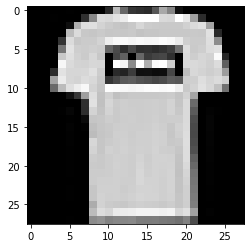

In [ ]:
print(labels[1])
plt.imshow(data[1], cmap='gray')

In [ ]:
# Defining image augumentations
from imgaug import augmenters as iaa

In [ ]:
seq = iaa.Sequential([
    iaa.Affine(rotate = 10),
    iaa.flip.HorizontalFlip()
])


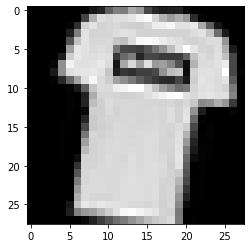

In [ ]:
plt.imshow(seq.augment_image(data[1]), cmap = 'gray')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
class FMNISTDataset(Dataset):
  def __init__(self, x, y, aug=None):
    super().__init__()
    self.X = x
    self.Y = y
    self.aug = aug
  
  def __getitem__(self, ix):
    x, y = self.X[ix], self.Y[ix]
    return x, y

  def __len__(self):
    return len(self.X)
  
  def collate_fn(self, batch):
    x, y = list(zip(*batch))
    if self.aug: 
      x = self.aug(images = x)
      x = torch.tensor(x)[:,None,:,:].to(device)/255.0
      y = torch.tensor(y).to(device)
      return x, y
  

  

In [ ]:
val_fmnist = datasets.FashionMNIST(datafolder, download=True, train = False)
val_images = val_fmnist.data
val_labels = val_fmnist.targets

In [ ]:
def get_data():
  fmnist = FMNISTDataset(data, target, aug = seq)
  train_loader = DataLoader(fmnist, batch_size=64, shuffle=True, collate_fn=fmnist.collate_fn)
  fmnist_val = FMNISTDataset(val_images, val_labels)
  val_loader = DataLoader(fmnist_val, batch_size=64, shuffle = True)
  return train_loader, val_loader

In [ ]:
from torch.optim import SGD, Adam
import torch.nn as nn
def get_model():
  model = nn.Sequential(
      nn.Conv2d(1, 64, kernel_size=3),
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Conv2d(64, 128, kernel_size=3),
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(3200, 256),
      nn.ReLU(),
      nn.Linear(256, 10)
  ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = Adam(model.parameters(), lr=1e-3)
  return model, loss_fn, optimizer


In [ ]:
def train_batch(x, y, model, opt, loss_fn):
  model.train()
  opt.zero_grad()
  prediction = model(x)
  loss = loss_fn(prediction, y)
  loss.backward()
  opt.step()
  return loss.item()


In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
from tqdm import tqdm
import numpy as np

In [ ]:

for epoch in tqdm(range(5)):
  losses = []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    losses.append(train_batch(x, y, model, optimizer, loss_fn))
  print(epoch, "======",np.mean(losses))

 20%|██        | 1/5 [00:22<01:30, 22.62s/it]

0 ====== 0.25753027946154067


 40%|████      | 2/5 [00:45<01:08, 22.71s/it]

1 ====== 0.22636609073323227


 60%|██████    | 3/5 [01:08<00:45, 22.73s/it]

2 ====== 0.20143262493902686


 80%|████████  | 4/5 [01:30<00:22, 22.69s/it]

3 ====== 0.17862602405107098


100%|██████████| 5/5 [01:53<00:00, 22.69s/it]

4 ====== 0.1561942945824249


In [ ]:
with torch.no_grad():
  model.eval()
  x_test = val_images[0]/255.0
  y_test = val_labels[0]
  x = torch.Tensor(x_test).view(-1,1,28,28).to(device)
  np_output = model(x).cpu().detach().numpy()

In [ ]:
np_output 

array([[ -6.116663  ,  -4.746373  , -14.225748  , -16.374582  ,
        -12.822632  ,  -0.09556689, -13.108806  ,  -0.2746216 ,
        -16.999022  ,  11.950649  ]], dtype=float32)

In [ ]:
np_output = np.exp(np_output)/np.sum(np.exp(np_output))

In [ ]:
np_output

array([[1.4238404e-08, 5.6049362e-08, 4.2828258e-12, 4.9946326e-13,
        1.7421922e-11, 5.8666496e-06, 1.3086163e-11, 4.9048717e-06,
        2.6749338e-13, 9.9998921e-01]], dtype=float32)

In [ ]:
np.argmax(np_output)

9

In [ ]:
y_test

tensor(9)

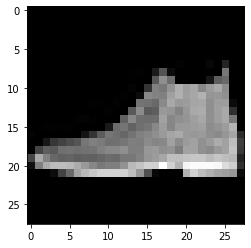

In [ ]:
plt.imshow(x_test,cmap='gray')

In [ ]:
labels[9]

'Ankle boot'

In [ ]:
torch.save(model.to('cpu').state_dict(), 'fmnist_5_epoch.pth')